<a href="https://colab.research.google.com/github/fhjgch/moksha-sports-club/blob/main/training_challenge_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path_old_data = "/content/drive/MyDrive/mtt_historic_raw_data_from_2023-09-27.csv"
path_new_data = "data-2024-6-10-16.csv"

In [ ]:
raw_df_new = pd.read_csv(path_new_data, thousands=',')
raw_df_old = pd.read_csv(path_old_data, thousands=',')

In [ ]:
raw_df_old.to_csv("/content/drive/MyDrive/mtt_historic_raw_data_from_2023-09-27_backup.csv", index=False)
raw_df = pd.concat([raw_df_old, raw_df_new], ignore_index=True).drop_duplicates().sort_values('Date', ascending=False)
# raw_df = raw_df_old.append(raw_df_new, ignore_index=True).drop_duplicates().sort_values('Date', ascending=False)
raw_df.to_csv("/content/drive/MyDrive/mtt_historic_raw_data_from_2023-09-27.csv", index=False)
# raw_df

# Backend

In [ ]:
# clean data
raw_df['Type'] = raw_df[' "Type"']
df = raw_df[[
    "Name", 'Type', "Date", "Distance", "Unit", "Duration", "EstSpeed"
]]
df['Date'] = pd.to_datetime(df['Date'], utc=True) + pd.Timedelta('01:00:00')#.apply(lambda x: x.datetime())
df['Duration'] = pd.to_datetime(df['Duration']).dt.minute + pd.to_datetime(df['Duration']).dt.hour * 60
# df = df.replace(regex=r'\w+\sRide$', value='Ride')
df = df.replace(regex=r'.*Ride$', value='Bike')
df = df.replace(regex=r'.*Run$', value='Run')
df = df.replace(regex=r'Daniel Brunner', value='Aakash Brunner ')
df.Distance = df.Distance.fillna(0)
df.loc[df.Type == "Swim", "Distance"] = df.loc[df.Type == "Swim", "Distance"] / 1000
df.loc[df.Type == 'unknown', 'Type'] = df.loc[df.Type == 'unknown'].apply(lambda x: 'Run' if x.Distance < 13 else 'Bike', axis=1)
df = df.drop_duplicates()
df

<ipython-input-29-2dd7fa43b368>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True) + pd.Timedelta('01:00:00')#.apply(lambda x: x.datetime())
<ipython-input-29-2dd7fa43b368>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Duration'] = pd.to_datetime(df['Duration']).dt.minute + pd.to_datetime(df['Duration']).dt.hour * 60
<ipython-input-29-2dd7fa43b368>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Duration'] = pd.t

,Name,Type,Date,Distance,Unit,Duration,EstSpeed
0,Dane Berry,Bike,2024-06-10 14:39:00+00:00,11.59,km,63,11.0
1,Ivan Cognata Timofeev,Run,2024-06-10 12:49:00+00:00,4.00,km,18,12.9
2,Aaron Govinda,Run,2024-06-09 17:48:00+00:00,10.84,km,58,11.1
3,Rohit Verma,Run,2024-06-09 16:45:00+00:00,5.01,km,33,8.9
4,Aakash Brunner,Run,2024-06-09 10:57:00+00:00,10.44,km,70,8.9
...,...,...,...,...,...,...,...
1156,Rohit Verma,Bike,2023-09-20 23:00:00+00:00,11.28,km,43,15.7
1157,Rohit Verma,Bike,2023-09-20 23:00:00+00:00,8.46,km,27,18.4
1158,Rohit Verma,Bike,2023-09-19 23:00:00+00:00,8.73,km,34,15.0
1159,Rohit Verma,Bike,2023-09-19 23:00:00+00:00,11.11,km,44,14.9


In [ ]:
def get_total_duration_per_athlete(start_time, end_time):
  a = df[(df.Date >= start_time) & (df.Date <= end_time)]
  return a.groupby(['Name'])['Duration'].sum().sort_values(ascending=False)
# get_total_duration_per_athlete('2023-11-05 00:00:00', '2023-11-06 00:00:00')

In [ ]:
def get_duration_per_type_and_athlete(start_time, end_time):
  a = df[(df.Date >= start_time) & (df.Date <= end_time)]
  return a.groupby(['Name', 'Type'])['Duration'].sum()

In [ ]:
def get_metric_per_type_and_athlete_2(start_time, end_time, ax, metric):
  x = df[(df.Date >= start_time) & (df.Date <= end_time)].groupby(['Type', 'Name'])[metric].sum().unstack().T.fillna(0)
  x = x.loc[x.fillna(0).sum(axis=1).sort_values(ascending=False).index]  # Sorted by Duration

  athletes = x.index.tolist()
  types = x.columns.tolist()
  bottom = np.zeros(len(athletes))

  c = ('tab:green', 'tab:orange', 'tab:blue')
  s = '(B) (R) (S)'.split()
  for j, typ in enumerate(types):
    p = ax.bar(athletes, x[typ], label=typ, bottom=bottom, color=c[j])
    for i, bar in enumerate(p):
      height = bar.get_height()
      if height:
        ax.annotate(f'{s[j]} {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height/2 + bottom[i]), xytext=(0, 0),
        textcoords="offset points", ha='center', va='center', size=9)
    bottom += x[typ].fillna(0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.legend()

  return ax

In [ ]:
def get_duration_per_athlete_and_type(start_time, end_time):
  a = df[(df.Date >= start_time) & (df.Date <= end_time)]
  return a.groupby(['Type', 'Name'])['Duration'].sum()

In [ ]:
def get_duration_per_athlete_and_type_2(start_time, end_time, ax):
  a = df[(df.Date >= start) & (df.Date <= end)].groupby(['Type', 'Name'])['Duration'].sum().unstack()

  a.plot(kind='bar', ax=ax, width=.85)

  for i, c in enumerate(ax.containers):
    labels = a.fillna(0).T.rank(ascending=False, method='max').astype(int).iloc[i]
    ax.bar_label(c, labels=labels, color='red')

  return ax

In [ ]:
def get_duration_per_athlete_and_type_3(start_time, end_time):
  a = df[(df.Date >= start) & (df.Date <= end)].groupby(['Type', 'Name'])['Duration'].sum().unstack()

  types = a.index.tolist()
  clrs = ('tab:green', 'tab:orange', 'tab:blue')

  figg, axx = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
  for i, typ, c in zip(np.arange(3), types, clrs):
    a.loc[typ].fillna(0).sort_values(ascending=True).plot(kind='barh', ax=axx[i], title=typ, color=c, ylabel='')
    axx[i].bar_label(axx[i].containers[0], label_type='center', color='white', width=.8, size=8)

In [ ]:
def get_distance_per_athlete_and_type(start_time, end_time):
  a = df[(df.Date >= start_time) & (df.Date <= end_time)].fillna(0)
  return a.groupby(['Type', 'Name'])['Distance'].sum()

# Make Stats

In [ ]:
start = '2023-09-27 00:00:00'
# start = '2024-06-03 00:00:00'
end = '2024-06-09 23:59:59'

In [ ]:
# df[(df.Date >= start) & (df.Date <= end) & (df.Name == 'Ganesh Jakob')]
# df[(df.Date >= start) & (df.Date <= end)]

### Duration

<ipython-input-32-45fb4b6dad53>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


Text(0, 0.5, 'Duration [min]')

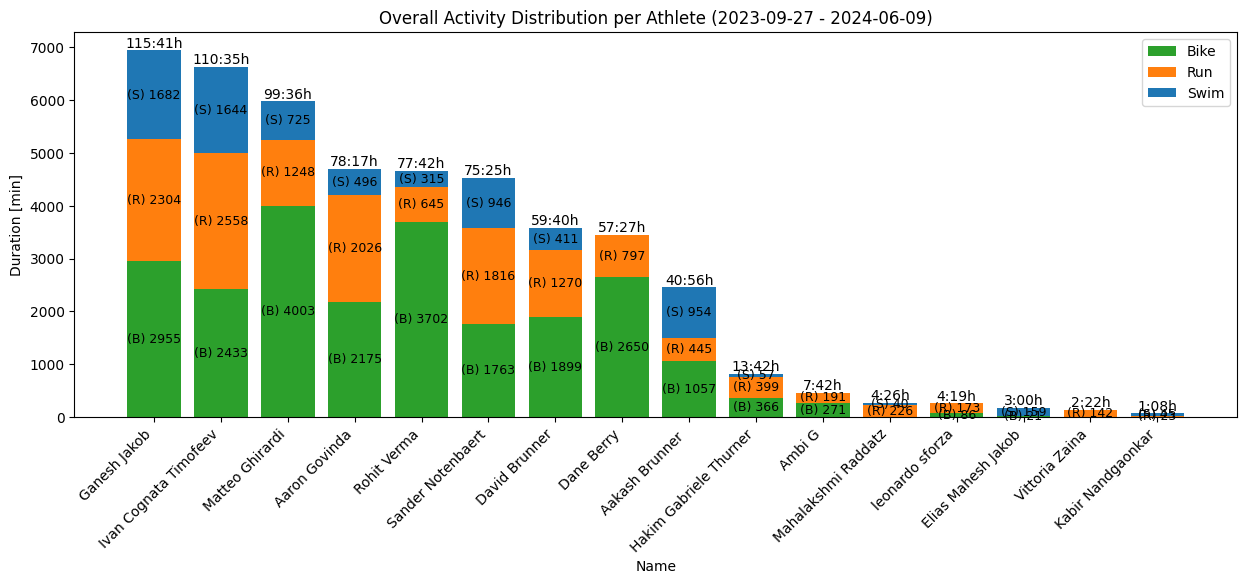

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

get_metric_per_type_and_athlete_2(start, end, ax, 'Duration')
ax.bar_label(
    ax.containers[-1],
    labels=[f'{int((v1+v2+v3)/60)}:{(v1+v2+v3)%60:02.0f}h'
            for v1, v2, v3 in zip(ax.containers[0].datavalues, ax.containers[1].datavalues, ax.containers[2].datavalues)],
    size=10
)
if start == '2023-09-27 00:00:00':
  ax.set_title(f'Overall Activity Distribution per Athlete ({start[:10]} - {end[:10]})')
else:
  ax.set_title(f'Weekly Activity Distribution per Athlete ({start[:10]} - {end[:10]})')
ax.set_xlabel('Name')
ax.set_ylabel('Duration [min]')

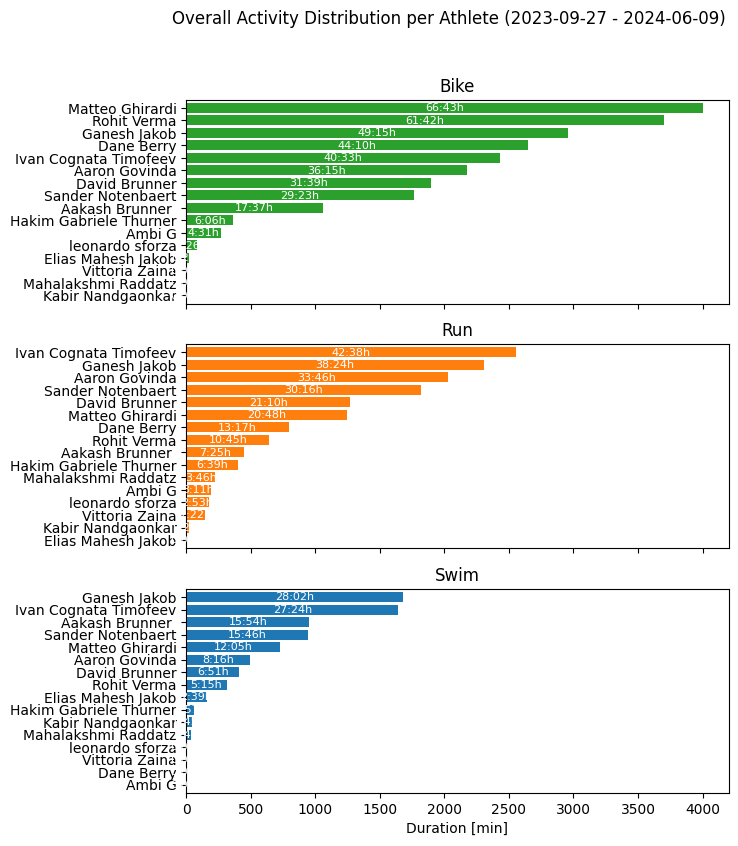

In [ ]:
a = df[(df.Date >= start) & (df.Date <= end)].groupby(['Type', 'Name'])['Duration'].sum().unstack()

types = a.index.tolist()
clrs = ('tab:green', 'tab:orange', 'tab:blue')

figg, axx = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i, typ, c in zip(np.arange(3), types, clrs):
  a.loc[typ].fillna(0).sort_values(ascending=True).plot(kind='barh', ax=axx[i], title=typ, width=.8, color=c, ylabel='')
  axx[i].bar_label(
      axx[i].containers[0],
      labels=[f'{int((v)/60)}:{(v)%60:02.0f}h' for v in axx[i].containers[0].datavalues],
      label_type='center', color='white', size=8)

axx[2].set_xlabel('Duration [min]')
if start == '2023-09-27 00:00:00':
  figg.suptitle(f'Overall Activity Distribution per Athlete ({start[:10]} - {end[:10]})')
else:
  figg.suptitle(f'Weekly Activity Distribution per Athlete ({start[:10]} - {end[:10]})')

### Distance

<ipython-input-32-45fb4b6dad53>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


Text(0, 0.5, 'Distance [km]')

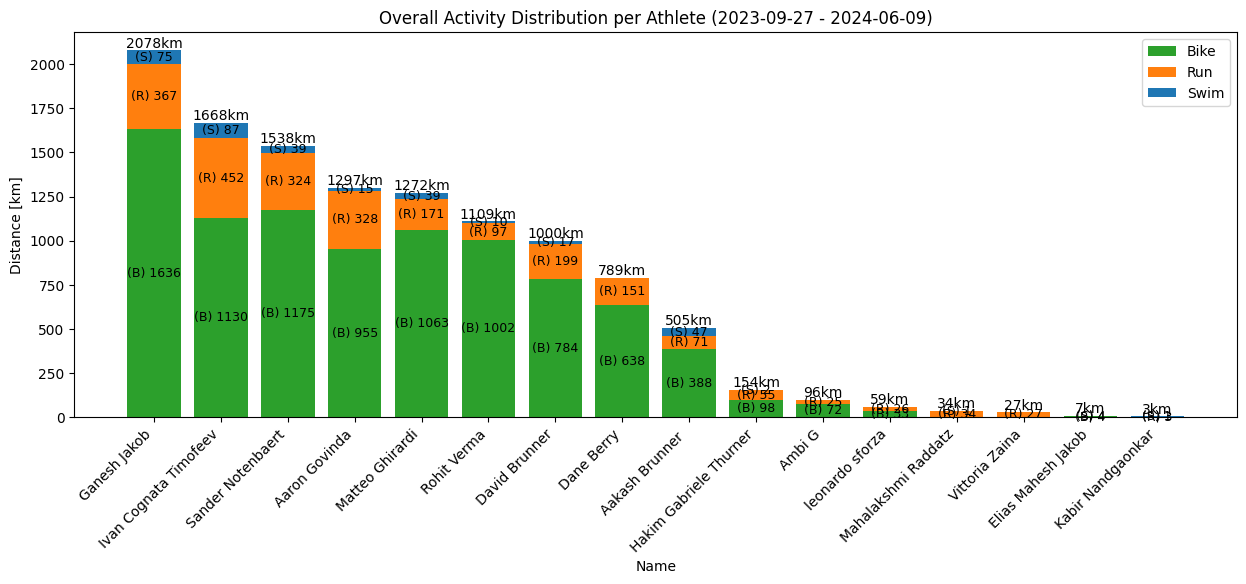

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

get_metric_per_type_and_athlete_2(start, end, ax, 'Distance')
ax.bar_label(
    ax.containers[-1],
    labels=[f'{int((v1+v2+v3))}km'
            for v1, v2, v3 in zip(ax.containers[0].datavalues, ax.containers[1].datavalues, ax.containers[2].datavalues)],
    size=10
)
if start == '2023-09-27 00:00:00':
  ax.set_title(f'Overall Activity Distribution per Athlete ({start[:10]} - {end[:10]})')
else:
  ax.set_title(f'Weekly Activity Distribution per Athlete ({start[:10]} - {end[:10]})')
ax.set_xlabel('Name')
ax.set_ylabel('Distance [km]')

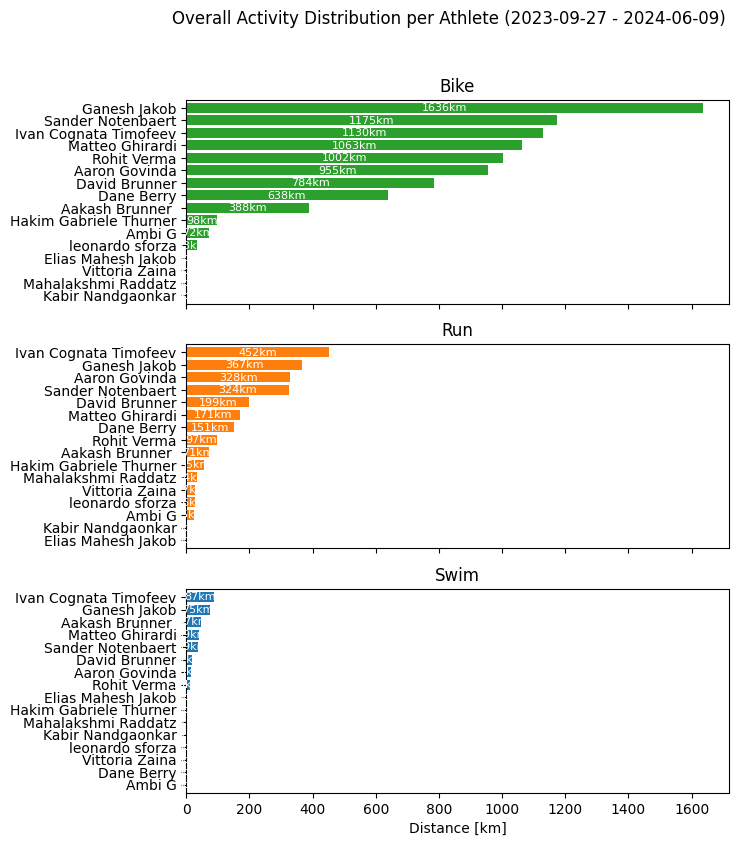

In [ ]:
a = df[(df.Date >= start) & (df.Date <= end)].groupby(['Type', 'Name'])['Distance'].sum().unstack()

types = a.index.tolist()
clrs = ('tab:green', 'tab:orange', 'tab:blue')

figg, axx = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i, typ, c in zip(np.arange(3), types, clrs):
  a.loc[typ].fillna(0).sort_values(ascending=True).plot(kind='barh', ax=axx[i], title=typ, width=.8, color=c, ylabel='')
  axx[i].bar_label(
      axx[i].containers[0],
      labels=[f'{v:.0f}km' for v in axx[i].containers[0].datavalues],
      label_type='center', color='white', size=8)

axx[2].set_xlabel('Distance [km]')
if start == '2023-09-27 00:00:00':
  figg.suptitle(f'Overall Activity Distribution per Athlete ({start[:10]} - {end[:10]})')
else:
  figg.suptitle(f'Weekly Activity Distribution per Athlete ({start[:10]} - {end[:10]})')

# Develop/Debug